In [1]:
import os
import gc

os.chdir('../../')

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, brier_score_loss
import joblib
from venn_abers import VennAbersCalibrator
from global_code.util import clf_metric_report, plot_pr_calib_curve, plot_dis_probs
import json

/Users/marcus.silva/Code/modern-ml/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the calibration data

In [3]:
train_df = pd.read_parquet('./week_1/data/processed/train_df_v2.parquet')
validation_df = pd.read_parquet('./week_1/data/processed/validation_df_v2.parquet')
calibration_df = pd.read_parquet('./week_1/data/processed/calibration_df_v2.parquet')
cat_features = ['country', 'broad_job_category']

target = 'churn_420'

# Input variables and Target dataframes
X_train, y_train= train_df.drop(target, axis=1), train_df.loc[:, target]
X_validation, y_validation= validation_df.drop(target, axis=1), validation_df.loc[:, target]
X_calibration, y_calibration= calibration_df.drop(target, axis=1), calibration_df.loc[:, target]

# Freeing memory
train_df = None
calibration_df = None
validation_df = None
gc.collect()

print('Train Shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_validation.shape, y_validation.shape)
print('Calibration shape: ', X_calibration.shape, y_calibration.shape)

Train Shape:  (306649, 183) (306649,)
Validation shape:  (283510, 183) (283510,)
Calibration shape:  (70878, 183) (70878,)


### Loading models

In [4]:
# Base model
# Load the baseline and feature selection models
baseline_model_path = './week_1/model/baseline_model.joblib'
feat_selection_model_path = './week_1/model/feat_selection_model.joblib'
tunned_model_path = './week_1/model/tunned_model.joblib'

baseline_model = joblib.load(baseline_model_path)
feat_selection_model = joblib.load(feat_selection_model_path)
tunned_model = joblib.load(tunned_model_path) 

champion_model = feat_selection_model

In [5]:
selected_features = None
with open('./week_1/model/selected_features_list.json', 'r') as f:
    selected_features = json.load(f)
print(selected_features)

['interest_rate', 'tenure', 'prior_10D_mean_days_between', 'prior_10D_mean_bank_transfer_in_volume', 'prior_90D_sum_days_between', 'prior_90D_max_days_between', 'prior_90D_min_days_between', 'prior_180D_sum_days_between', 'prior_180D_mean_days_between', 'prior_180D_max_days_between', 'prior_180D_min_days_between', 'prior_365D_sum_days_between', 'prior_365D_mean_days_between', 'prior_450D_sum_days_between', 'prior_450D_mean_days_between', 'prior_450D_std_days_between', 'prior_450D_max_days_between', 'prior_450D_mean_balance', 'prior_sum_days_between', 'prior_std_days_between', 'prior_mean_days_between', 'prior_max_days_between', 'prior_mean_bank_transfer_in', 'prior_mean_bank_transfer_out', 'prior_mean_bank_transfer_in_volume', 'prior_sum_crypto_in_volume', 'prior_crypto_balance', 'prior_mean_balance', 'country', 'broad_job_category']


### Calibrate the model using Platt scaling (sigmoid) and isotonic regression

In [6]:
# Platt scaling (sigmoid)
print('Fitting platt scaling calibration...')
calibrated_model_sigmoid = CalibratedClassifierCV(champion_model, method='sigmoid')
calibrated_model_sigmoid.fit(X_calibration[selected_features], y_calibration)
y_pred_sigmoid = calibrated_model_sigmoid.predict_proba(X_validation[selected_features])[:, 1]


Fitting platt scaling calibration...
0:	learn: 0.0302923	total: 75.7ms	remaining: 1m 15s
1:	learn: 0.0326844	total: 95.1ms	remaining: 47.5s
2:	learn: 0.0354929	total: 112ms	remaining: 37.4s
3:	learn: 0.0405590	total: 131ms	remaining: 32.6s
4:	learn: 0.0427026	total: 148ms	remaining: 29.4s
5:	learn: 0.0431407	total: 167ms	remaining: 27.6s
6:	learn: 0.0433357	total: 185ms	remaining: 26.2s
7:	learn: 0.0466207	total: 204ms	remaining: 25.3s
8:	learn: 0.0470163	total: 222ms	remaining: 24.5s
9:	learn: 0.0464385	total: 236ms	remaining: 23.3s
10:	learn: 0.0459037	total: 248ms	remaining: 22.3s
11:	learn: 0.0450025	total: 266ms	remaining: 21.9s
12:	learn: 0.0472348	total: 285ms	remaining: 21.6s
13:	learn: 0.0465231	total: 298ms	remaining: 21s
14:	learn: 0.0482487	total: 314ms	remaining: 20.6s
15:	learn: 0.0488983	total: 334ms	remaining: 20.5s
16:	learn: 0.0488686	total: 348ms	remaining: 20.1s
17:	learn: 0.0487228	total: 358ms	remaining: 19.5s
18:	learn: 0.0481544	total: 375ms	remaining: 19.4s
19:

In [7]:
# Isotonic regression
print('Fitting isotonic regression calibration...')
calibrated_model_isotonic = CalibratedClassifierCV(champion_model, method='isotonic')
calibrated_model_isotonic.fit(X_calibration[selected_features], y_calibration)
y_pred_isotonic = calibrated_model_isotonic.predict_proba(X_validation[selected_features])[:, 1]

Fitting isotonic regression calibration...
0:	learn: 0.0302923	total: 19.6ms	remaining: 19.6s
1:	learn: 0.0326844	total: 38.6ms	remaining: 19.3s
2:	learn: 0.0354929	total: 57.4ms	remaining: 19.1s
3:	learn: 0.0405590	total: 76.5ms	remaining: 19.1s
4:	learn: 0.0427026	total: 96.3ms	remaining: 19.2s
5:	learn: 0.0431407	total: 115ms	remaining: 19s
6:	learn: 0.0433357	total: 135ms	remaining: 19.2s
7:	learn: 0.0466207	total: 153ms	remaining: 19s
8:	learn: 0.0470163	total: 171ms	remaining: 18.9s
9:	learn: 0.0464385	total: 186ms	remaining: 18.5s
10:	learn: 0.0459037	total: 200ms	remaining: 18s
11:	learn: 0.0450025	total: 221ms	remaining: 18.2s
12:	learn: 0.0472348	total: 239ms	remaining: 18.2s
13:	learn: 0.0465231	total: 252ms	remaining: 17.8s
14:	learn: 0.0482487	total: 271ms	remaining: 17.8s
15:	learn: 0.0488983	total: 291ms	remaining: 17.9s
16:	learn: 0.0488686	total: 306ms	remaining: 17.7s
17:	learn: 0.0487228	total: 320ms	remaining: 17.4s
18:	learn: 0.0481544	total: 346ms	remaining: 17.9s

In [8]:
# Compute metrics for Platt scaling and isotonic regression
print("Platt Scaling (Sigmoid) Metrics:")
clf_metric_report(y_pred_sigmoid, y_validation)

print("\nIsotonic Regression Metrics:")
clf_metric_report(y_pred_isotonic, y_validation)

Platt Scaling (Sigmoid) Metrics:
Evaluating the model...
ROC AUC: 0.6684391699151279
Brier Score: 0.013683769604319896
Average Precision: 0.02514444414846013
Log Loss: 0.07139425445587762

Isotonic Regression Metrics:
Evaluating the model...
ROC AUC: 0.667552784524515
Brier Score: 0.01367475036920228
Average Precision: 0.025130880644242813
Log Loss: 0.0709236353664656


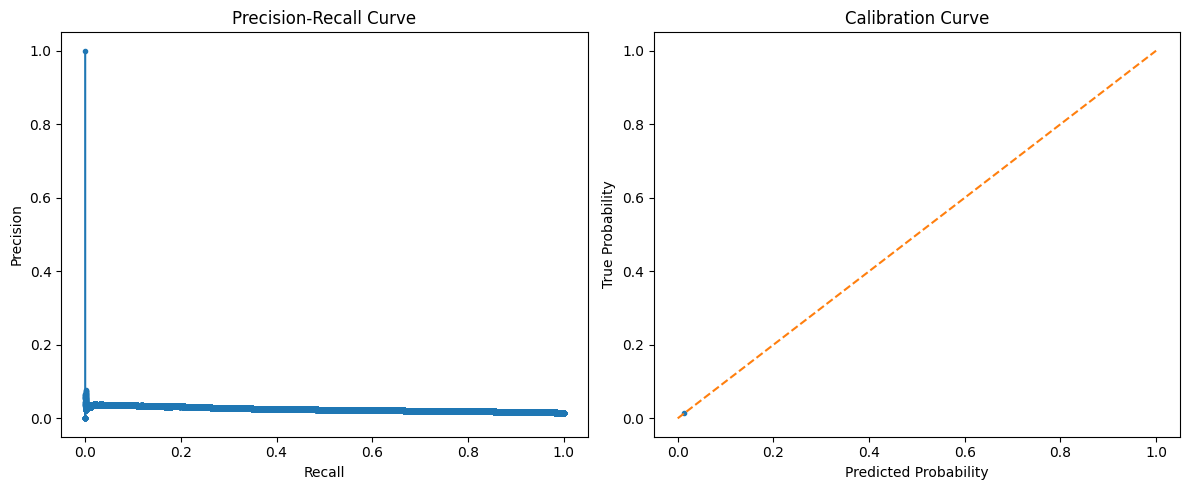

In [9]:
# Plot the calibration curve
plot_pr_calib_curve(y_pred_sigmoid, y_validation)

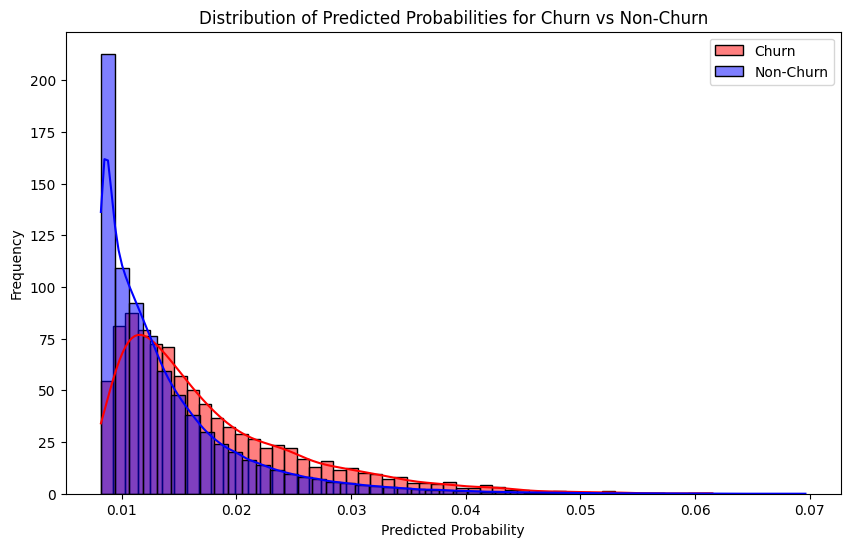

In [10]:
plot_dis_probs(y_pred_sigmoid, y_validation)

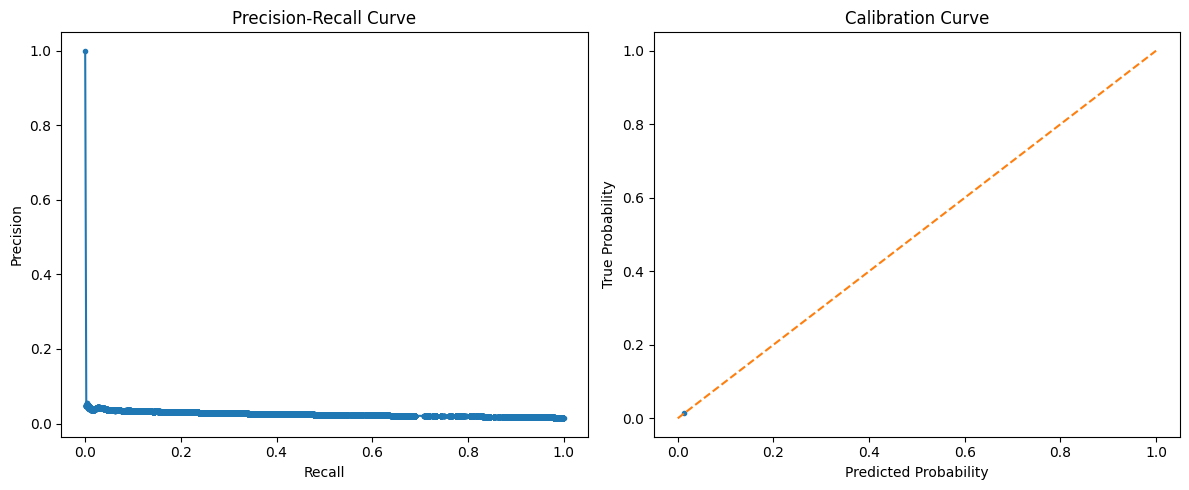

In [11]:
# Plot the calibration curve
plot_pr_calib_curve(y_pred_isotonic, y_validation)

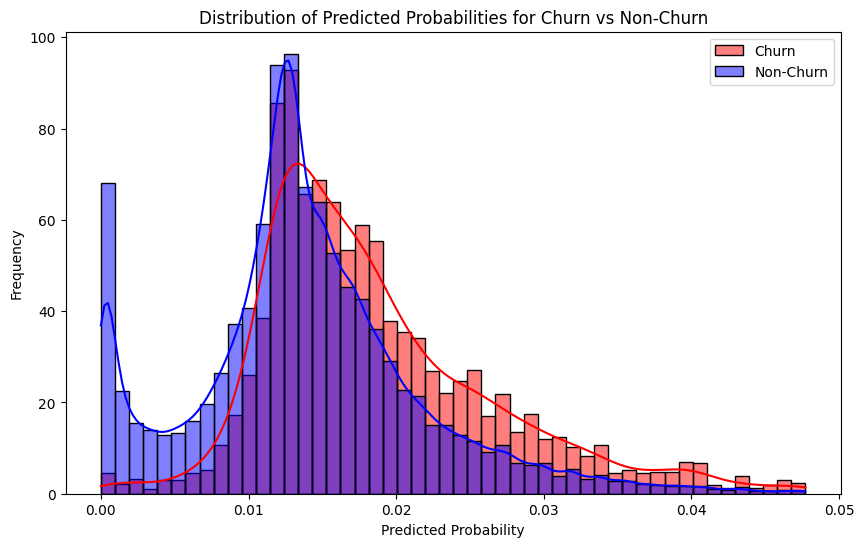

In [12]:
plot_dis_probs(y_pred_isotonic, y_validation)

### Calibrate the model using Venn-Abers

In [13]:
p_cal = tunned_model.predict_proba(X_calibration[selected_features])
p_test = tunned_model.predict_proba(X_validation[selected_features])

va = VennAbersCalibrator()
va_prefit_prob = va.predict_proba(p_cal=p_cal, y_cal=y_calibration.values, p_test=p_test)
y_pred_va = va_prefit_prob[:, 1]

/Users/marcus.silva/Code/modern-ml/.venv/lib/python3.11/site-packages/venn_abers/venn_abers.py:104: RuntimeWarning: All-NaN slice encountered
  if np.sum(np.isnan(np.nanmin(grads))) == 0:


In [14]:
# Compute metrics for Venn-Abers calibration
print("\nVenn-Abers Calibration Metrics:")
clf_metric_report(y_pred_va, y_validation)


Venn-Abers Calibration Metrics:
Evaluating the model...
ROC AUC: 0.6915497971966293
Brier Score: 0.013644683152994198
Average Precision: 0.02887737654134629
Log Loss: 0.06968174019003853


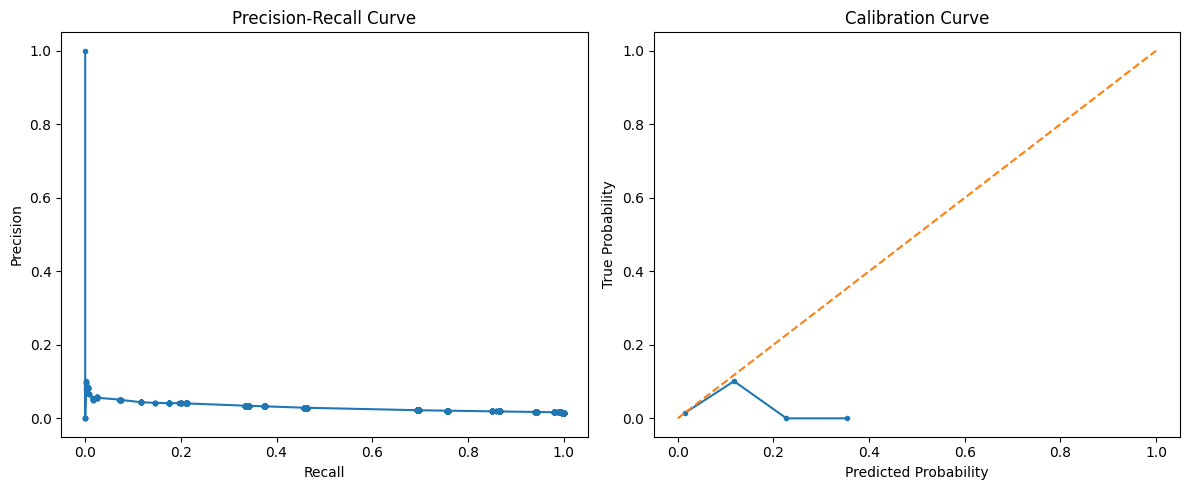

In [15]:
# Plot the calibration curve
plot_pr_calib_curve(y_pred_va, y_validation)

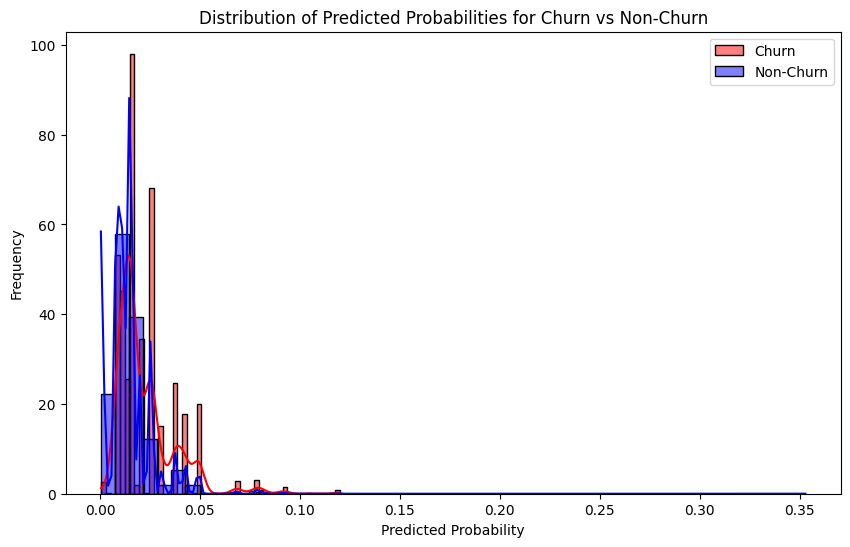

In [16]:
plot_dis_probs(y_pred_va, y_validation)

### Compare the models

In [18]:
# Predict using the baseline model
y_pred_baseline = baseline_model.predict_proba(X_validation)[:, 1]

# Predict using the feature selection model
y_pred_feat_selection = feat_selection_model.predict_proba(X_validation[selected_features])[:, 1]

# Predict using the tunned model
y_pred_tunned= tunned_model.predict_proba(X_validation[selected_features])[:, 1]

# Compare the models using clf_metric_report
print("Baseline Model Metrics:")
clf_metric_report(y_pred_baseline, y_validation)

print("\nFeature Selection Model Metrics:")
clf_metric_report(y_pred_feat_selection, y_validation)

print("\nTuned Model Metrics:")
clf_metric_report(y_pred_tunned, y_validation)

print("\nChampion Platt Scaling (Sigmoid) Metrics:")
clf_metric_report(y_pred_sigmoid, y_validation)

print("\nnChampion Isotonic Regression Metrics:")
clf_metric_report(y_pred_isotonic, y_validation)

print("\nnChampion Venn-Abers Calibration Metrics:")
clf_metric_report(y_pred_va, y_validation)

Baseline Model Metrics:
Evaluating the model...
ROC AUC: 0.6875439449160486
Brier Score: 0.2730737709354406
Average Precision: 0.028297423279297983
Log Loss: 0.7281983181929316

Feature Selection Model Metrics:
Evaluating the model...
ROC AUC: 0.7014742043971451
Brier Score: 0.27642400397512024
Average Precision: 0.031005618914571025
Log Loss: 0.7381139396803066

Tuned Model Metrics:
Evaluating the model...
ROC AUC: 0.6934818907556093
Brier Score: 0.024412398374578502
Average Precision: 0.030587770785982994
Log Loss: 0.13889383153464352

Champion Platt Scaling (Sigmoid) Metrics:
Evaluating the model...
ROC AUC: 0.6684391699151279
Brier Score: 0.013683769604319896
Average Precision: 0.02514444414846013
Log Loss: 0.07139425445587762

nChampion Isotonic Regression Metrics:
Evaluating the model...
ROC AUC: 0.667552784524515
Brier Score: 0.01367475036920228
Average Precision: 0.025130880644242813
Log Loss: 0.0709236353664656

nChampion Venn-Abers Calibration Metrics:
Evaluating the model...